# Module 12: Time series analysis

## Outline

* Concepts
* Types of time series
* Analysing components
* Frequency domain representations of time series

* Mid-term evaluation

## Motivation

So the aim of time series analysis is:

* **To identify and model different components**

...in order to:
- **to provide an understanding of the physical mechanisms/processes**
- **to simulate and predict the data**

##### Today's question
> ** How can we a model the processes that produced the observed data?**

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import scipy

import warnings
warnings.filterwarnings('ignore')

## The concept of time series

A time series is a sequence of values of a particular variable collected over time.
So the **ordering of the data in time is important** to their information content.

* Values can be single samples, or time averages of multiple sample
    - The **time stamp** can represent the start, middle or end of the time interval
    - The **time zone** needs to be specified

So before you start your time series analysis, you should have a look at the **metadata**.

<IPython.core.display.Javascript object>


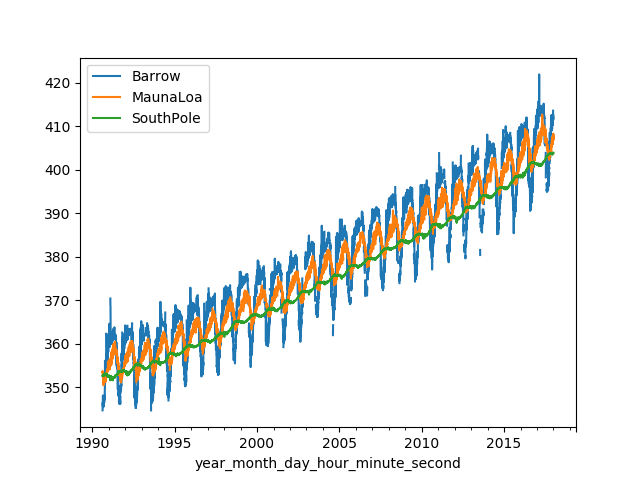

In [2]:
# How would you describe these time series of atmospheric CO2 concentrations?
# Do you see a random and systematic features?

my_parse=lambda x: datetime.datetime.strptime(x, '%Y %m %d %H %M %S')

barrow_co2 = pd.read_csv('barrow_co2.csv', index_col=0, parse_dates=[[1,2,3,4,5,6]], date_parser=my_parse,
                          skiprows=146, sep=' ',
                          na_values=['-999.99'])

maunaloa_co2 = pd.read_csv('maunaloa_co2.csv', index_col=0, parse_dates=[[1,2,3,4,5,6]], date_parser=my_parse,
                          skiprows=147, sep=' ',
                          na_values=['-999.99'])

southpole_co2 = pd.read_csv('southpole_co2.csv', index_col=0, parse_dates=[[1,2,3,4,5,6]], date_parser=my_parse,
                          skiprows=146, sep=' ',
                          na_values=['-999.99'])

barrow_co2=barrow_co2[['value']].rename(columns={'value':'Barrow'})
maunaloa_co2=maunaloa_co2[['value']].rename(columns={'value':'MaunaLoa'})
southpole_co2=southpole_co2[['value']].rename(columns={'value':'SouthPole'})

df_co2=barrow_co2.join(maunaloa_co2).join(southpole_co2)

df_co2[-10000:].plot()
plt.legend()


#### Dealing with gaps and irregular time steps

* Time steps can be regular or irregular, which makes an important difference when interpolating missing values

In [3]:
# Example: interpolating irregular time steps

ts_index = pd.to_datetime(['2019-11-01','2019-11-02','2019-11-06'])

ts_values= [1, np.nan, 2]

ts = pd.DataFrame(ts_values, index=ts_index)

ts.interpolate(method='time')  #


,0
2019-11-01,1.0
2019-11-02,1.2
2019-11-06,2.0


In [4]:
# to deal with gaps in the time series, you could also resample to regular time steps first
# and interpolate any remaining gaps

df_co2_month=df_co2.resample('1M').mean().interpolate().dropna()

# (we'll use this time series later...)

## Types of time series

We describe time series with the sample estimates of the usual statistics:
* Mean
* Variance
* Auto-covariance:
$$cov(X_t,X_{t+L})=E[(X_t -\bar{X})(X_{t+L} -\bar{X})]$$

* Autocorrelation at lag $L$:
$$\rho_L=cor(x_t,x_{t+L})=\frac{cov(x_t,x_{t+L})}{\sqrt{var(x_t)var(x_{t+L})}}$$

The latter two describe **_linear_ temporal correlations**, which are particularly important in many geophysical systems (with "memory" or storage).

The graph of $\rho_L$ against $L$ is called correlogram. If the autocorrelation for any lag $L\ne 0$ is zero, the time series (or process) is called **purely random (or noise)**.

### Stationarity

If the sample statistics are **constant in time** the time series (or process) is **stationary**.
This means that different parts of a stationary time series **look alike statistically**, even though the individual data values may be very different.

* **Strict stationarity** means all sample moments are constant in time.

* If the first two moments are constant in time, the time series is said to be **second-order stationary** or **weakly stationary** (often used when higher-order moments are unreliable)

* If the statistics of **parts of the time series** are not significantly different, the time series is called **self-stationary**. 

If the statistics of the sample do depend on time, the time series or process is **non-stationary**.

This can be due to trends, jumps, seasonality, or heteroscedasticity.

<IPython.core.display.Javascript object>


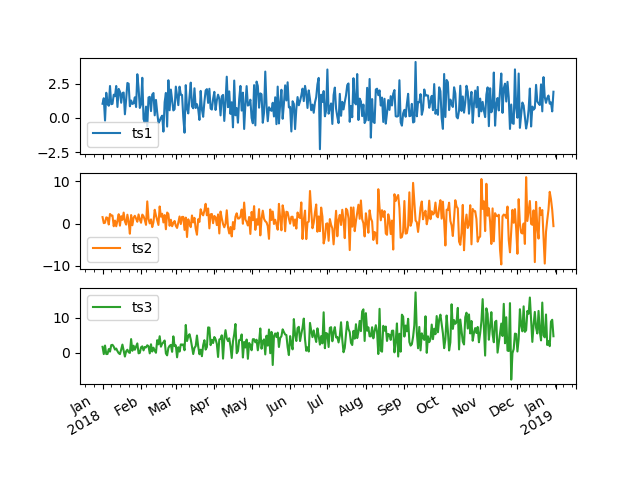

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10b4f0d30>,
      dtype=object)

In [5]:
# let's look at some synthetic time series
ts_days = np.arange('2018-01-01', '2018-12-31', dtype='datetime64[D]')

ts1,ts2,ts3=[],[],[]

for t in range(len(ts_days)):
    ts1.append( np.random.normal(loc=1., scale=1.) )
    
    ts2.append( np.random.normal(loc=1., scale=1+0.01*t) )
    
    ts3.append( np.random.normal(loc=1+0.02*t, scale=1+0.01*t) )

    
ts_gaussian_df = pd.DataFrame({'ts1':ts1,'ts2':ts2,'ts3':ts3}, index=ts_days)

ts_gaussian_df.plot(subplots=1)


## Analysing components of a time series

To deal with non-stationarity we can model and subtract systematic components.

So we think of the time series to consist of a **deterministic component** $D(t)$ and a **stochastic component** $E(t)$: 

$$ X(t)=D(t)+E(t) $$

* $D(t)$ represents variations that can be expressed as a function of time
* $D(t)$ contains the trend and the periodic component
    - trends can be linear or non-linear
    - periodicity can usually be described by a combination of sine functions
* $E(t)$ represents the random fluctuations


<IPython.core.display.Javascript object>


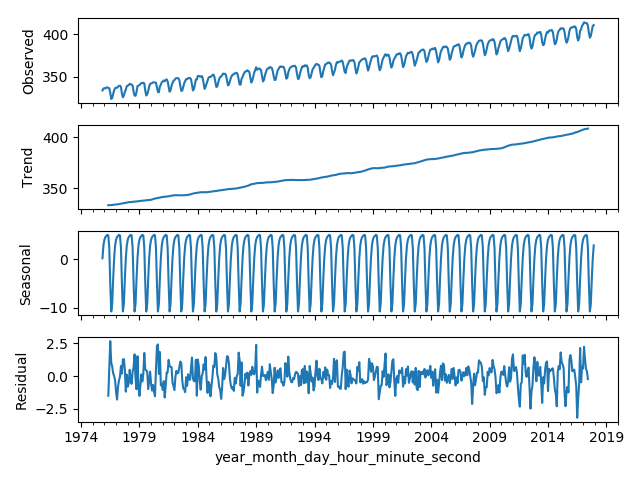

In [6]:
# In some cases, a simple decomposition using moving averages can already be informative
# here, assuming an additive model: Y[t] = T[t] + S[t] + e[t]

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(df_co2_month['Barrow']).plot()


#this decomposition can be regarded as a model that produces the observed data

## Testing for deterministic components

#### Wald–Wolfowitz runs test

...or simply the runs test.

This is a non-parametric **test for randomness based on serial correlation**, i.e. it tests the hypothesis that the elements of a time series are mutually independent.

If this null hypothesis is discarded, the time series may contain a trend, periodicity, or otherwise **systematic features**.

**Procedure:**
* Calculate a **cutoff** as mean or median of the time series

* Compare every observation with the cutoff, to see if it's larger (+) or smaller (-) than the cutoff

* Calculate the number of observations above ($n_1$) and below ($n_2$) the cutoff

* Calculate the **number of runs** ($R$), defined as a sequence of successive + or - signs
    - e.g.: ++-+++--+--- has 6 runs

* For large $n_1, n_2$ ($>10$) the distribution of $R$ under the null hypothesis is approximated by a **normal distribution** with mean
    - $\mu = \frac{2 n_1 n_2}{n_1 + n_2}+1$

* and variance
    - $\sigma^2 = \frac{2 n_1 n_2 (2 n_1 n_2 - n_1 - n_2)}{(n_1 + n_2)^2 (n_1 + n_2 -1)}$

* We may use the z-statistic $Z=(R-\mu)/\sigma$ and compare it with the standard normal distribution N(0,1): https://en.wikipedia.org/wiki/Standard_normal_table#Cumulative

* If $|Z|>Z_{1-\alpha/2}$ we reject the hypothesis that the time series is random

The runs test can also be used to test if a function fits a dataset. Since it only accounts for the signs (+ or -) but not the distance to the fitted line, it can be regarded complementary to the Chi-square test.

In [8]:
# The Statsmodels package implements the runs test
# it returns the z- and two sided p-value

from statsmodels.sandbox.stats.runs import runstest_1samp

# let's test the sequence [1,2,3,4,5,6,7,8,9,10,11], or ts_gaussian_df['ts3']

runstest_1samp([1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1], cutoff='mean', correction=False)


(3.786054440175419, 0.00015305815632077525)

<IPython.core.display.Javascript object>


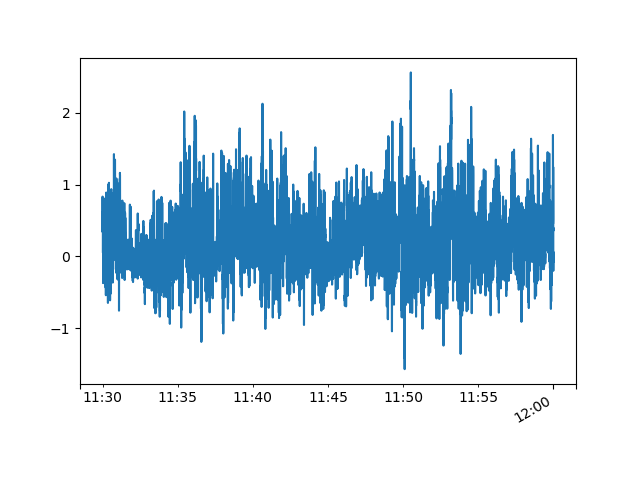

(-94.0256841155853, 0.0)

In [9]:
# if ever you're in doubt if some of your data is signal or noise...

EC_df = pd.read_csv('2018-08-13T113000.csv',index_col=0,parse_dates=True)
EC_df['w_m/s'].plot(subplots=True)

runstest_1samp(EC_df['w_m/s'], cutoff='mean', correction=False)


#### Linear-regression method

We can use a t-test to detect a trend. In contrast to the previous test, this is a parametric test where we assume the residuals of the data to be normally distributed (this may be assessed in *probability plots*).

Procedure:

* Fit a linear regression equation with time $T$ as independent variable 
$$ Y=\alpha + \beta T $$

* If $\beta$ is significantly different from zero, there is a trend

The null hypothesis of no trend is tested by the test statstic:
$$t=\frac{\beta-0}{S_\beta}$$

with the standard deviation of $\beta$:
$$S_\beta=\frac{S}{\sqrt{\sum(T_i-\bar{T})^2}}$$

and the standard error of the regression:
$$ S=\sqrt{ \frac{1}{n-2} \sum (Y_i - \hat{Y_i} )^2} $$

* The null hypothesis is rejected if $|t|>t_{1-\alpha/2 , n-2}$

In [ ]:
# We first need to convert our time stamps into numbers
ts_gaussian_df['julian_date'] = ts_gaussian_df.index.to_julian_date()
ts_gaussian_df.head()

In [ ]:
from statsmodels.formula.api import ols

plt.plot(ts_gaussian_df['julian_date'], ts_gaussian_df['ts3'])

model = ols("ts3 ~ julian_date", ts_gaussian_df).fit()
print(model.summary())


#### Mann-Kendall trend test

Mann-Kendall trend test is a non-parametric test used to **identify a trend** (linear or non-linear) in a series, even if there is a seasonal component in the series. So it does not assume the data to be distributed according to any particular rule, like normally distributed.

The null hypothesis for the test is that there is no trend in the series.

The test statistic
$$S=\sum_{i=1}^{n-1} \sum_{j=i+1}^{n} sgn(x_j-x_i)$$

is normally distributed (with mean=0) given the null hypothesis (and if sample size $n>7$).

The variance of this normal distribution depends on the number of equal values ($q$, ties) in the time series:
$$ var(S) = \frac{n (n-1) (2 n+5) - \sum_{p=1}^{q} (t_p (t_p-1) (2 t_p+5))}{18} $$

where $t_p$ is the number of ties for the p-th value. As in the runs test, we compare the standardised MK test statistic with N(0,1) to test the null hypothesis:

$$ Z_{MK} =
  \begin{cases}
    \frac{S-1}{\sqrt{var(S)}} & \quad \text{if } S>0 \\
    0 & \quad \text{if } S=0 \\
    \frac{S+1}{\sqrt{var(S)}} & \quad \text{if } S>0
  \end{cases} $$

In [ ]:
from scipy.stats import norm

def MK_test(x):
    n = len(x)
    S = 0
    for i in range(n-1):
        for j in range(i+1, n):
            S += np.sign(x[j] - x[i])

    # number of tied groups
    q = len(np.unique(x)) # number of unique values

    # number of ties for the p-th value
    tp = np.zeros(np.unique(x).shape)
    for i in range(q):
        tp[i] = sum(x == np.unique(x)[i])

    var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    # calculate the MK test statistic Z_MK
    if S > 0:
        Z_MK = (S - 1)/np.sqrt(var_s)
    elif S < 0:
        Z_MK = (S + 1)/np.sqrt(var_s)
    else:
        Z_MK = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(Z_MK))) #two tailed test

    print("sample size="+str(n))
    print("S="+str(S))
    print("var(S)="+str(var_s))
    print("Z_MK="+str(Z_MK))
    print("p-value="+str(p))


In [ ]:
MK_test([1,2,3,4])


### Jumps

If you suspect jumps in a time series without a trend, you can devide the time series at that point and test if $\mu_1=\mu_2$.

## Periodicity

Periodicity or seasonality in a time series can be investigated quantatively with different methods.

### Autocorrelation method

Periodicities in a signal may be recognised as positive peaks in the **autocorrelation coefficients** $r_L$ for a range of time lags $L$. This method consists of two steps:

#### 1. Calculate the autocorrelation coefficients $r_L$ for a range of time lags $L$ (typically $0<L<n/4$)

$$ r_L = \frac{1}{n-L} \sum_{t=1}^{n-L} (X_t-\bar{X}) (X_{t+L} - \bar{X}) / \frac{1}{n} \sum_{t=1}^n (X_t-\bar{X})^2$$


* Alternative estimates for $r_L$ use different normalisations (e.g. $1/n$ in Pandas instead of $1/(n-L)$).

* A plot of $r_L$ against $L$ is called **correlogram**.

* If $r_L \approx 0$ for $L \ne 0$, the time series describes a **purely random process**. This indicates that observations are **linearly independent**.

* If $r_L \ne 0$ for some $L \ne 0$, but become zero after $L>\tau$, then the time series is **stationary but not independent**. It is still refered to as a random process, but it has a memory of about $\tau$.

* If $r_L \ne 0$ for all $L \ne 0$, it is a **non-stationary time series**, because the data contains a cyclic (deterministic) component.

#### 2. Test the significance of $r_L$

If $n$ gets large, $r_L$ will be approximately normally distributed with mean $\frac{-1}{n-1} \approx 0$ and variance $\frac{n-2}{(n-1)^2}$ under the null hypothesis ($r_L=0$) (see Haan 2002 for details).

The confidence limits of $r_L$ are estimated by:

$$ l = -z_{1-\alpha /2} \sqrt{n-2} / (n-1)$$

$$ u = +z_{1-\alpha /2} \sqrt{n-2} / (n-1)$$


In [ ]:
def my_autocorrelation(x):
    n=len(x)
    r_L=[]
    for L in range(n):
        c_h=1/(n-L)*sum( [(x[t]-np.mean(x))*(x[t+L]-np.mean(x)) for t in range(n-L)] )
        #alternative estimations may normalise differently, e.g. with 1/n
        
        c_0=1/n* sum([(x[t]-np.mean(x))**2 for t in range(n)])
        r_L.append(c_h/c_0)
        
    return r_L


#use this function to plot the correlogram:

#ts=np.random.random(100)
#ts=np.sin(np.linspace(0,25,100))
ts=df_co2_month['Barrow']


fig=plt.figure()
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)
ax1.plot(ts)
ax2.plot(my_autocorrelation(ts))
#pd.plotting.autocorrelation_plot(ts, ax=ax2)

n=len(ts)

lower=-1/(n-1) - norm.ppf(.975)*np.sqrt(n-2)/(n-1)
upper=-1/(n-1) + norm.ppf(.975)*np.sqrt(n-2)/(n-1)
ax2.axhspan(lower, upper, facecolor='0.5', alpha=0.5)


## Frequency domain representations of time series

A different way to look at a time series is by **partitioning** its variance to different frequencies.

A Fourier transform is a decomposition into **$n$ individual, scaled and shifted, cosine functions**.

Even if the underlying physical basis for a time series is **not well represented by a series of cosine waves**, often much can still be learned about the data by **viewing it as a collection of coefficients (scaling and shifting)** that are a function of frequency.

Mathematically, for a finite time series $x_n$ of uniformly spaced samples at times $n = 0,1,...,N-1$, the discrete Fourier transformation is:

$$ X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i \, 2 \pi \, k \, n/N} $$

(using the Euler complex exponential notation, $exp(ix)=cos(x)+i\cdot sin(x)$).

Or equivalently in matrix notation:

$$ \vec{X_{}} = M \cdot \vec{x_{}} $$

with

$$ M_{kn} = e^{-i \, 2 \pi \, k \, n/N} $$

In [12]:
def my_discrete_fourier_transform(x):
    x = np.asarray(x)
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    M = np.exp(-2j * np.pi * k * n / N)
    
    return np.dot(M, x)

### Some notes:

* Ideally, we want **equally spaced input data with no missing values**

* Fourier coefficients are in general **complex valued** (often interpreted by their amplitude and phase)

* The lowest frequency, $2\pi/N$ (the **fundamental frequency**) corresponds to the cosine wave that executes a single cycle over the $N$ time points

* The highest frequency is called the **Nyquist frequency** (half the sampling frequency $1/\delta t$)

Nyquist frequency depends on the time resolution of the original data series



In [13]:
def plot_fourier_transform(t, x, windowing=False):
    dt=np.diff(t)[0] #assuming equal spacing
    f_s=1./dt
    
    N = len(x)
    k = np.arange(N)

    T = N/f_s #total time period sampled
    
    frq = k/T
    
    #get the complex Fourier coefficients
    X = my_discrete_fourier_transform(x)
    
    
    fig = plt.figure()
    ax1=fig.add_subplot(211)
    ax1.plot(t, x)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('x(t)')

    ax2=fig.add_subplot(212)
    ax2.plot(frq, 1.0/N * np.abs(X)) #it is also common to use 2/N as the normalisation here
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('1/N * abs( X(f) )')
    
    if windowing:
        win = np.kaiser(len(t), 5)
        X_win = my_discrete_fourier_transform(x * win)
        ax1.plot(t, x* win)
        ax2.plot(frq, 2.0/N * np.abs(X_win))
    
    return [ax1,ax2]

<IPython.core.display.Javascript object>


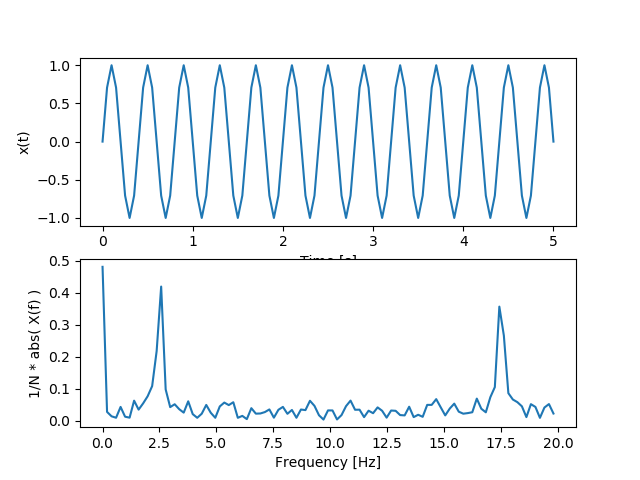

In [30]:
# Examples: 

# let's say we sample a signal over 5.5 seconds with 20 Hz
t = np.arange(0, 5.05, 0.05)

#y = np.sin(2*np.pi *1. *t) #a 1 Hz oscillation sampled at 20 Hz

#y = np.sin(2*np.pi *1./3. *t) + np.sin(2*np.pi *1. *t)

#y = np.sin(2*np.pi *1./3. *t) + 2.*np.sin(2*np.pi *1. *t)

#y = np.sin(2*np.pi *1./3. *t) + np.sin(2*np.pi *1. *t) + np.sin(2*np.pi *22.5 *t)

#y = np.sin(2*np.pi *1./3. *t) + np.sin(2*np.pi *2. *t) + np.sin(2*np.pi *7. *t) +3*np.random.random(len(t))

y = np.sin(2*np.pi *2.5 *t)  + 1j*np.random.random(len(t))

#plot power spectrum
plot_fourier_transform(t, y, windowing=False)
#print(sum(y))

### Aliasing
If the points in the time series are spaced too far apart to properly represent fast variations, the signal is said to be **undersampled.**

However, variations that occur at frequencies higher than the Nyquist frequency do not disappear. Rather, their contributions are spuriously attributed to some lower but representable frequency. These high-frequency variations are said to be **aliased**.

#### More notes

* The **inverse Fourier transformation** recovers the original signal in the time domain
    - When we plot the spectrum, we often only show the amplitude (or the squared coefficients), which omits the information contained in the phase
    - so the original signal could not be reconstructed from the power spectrum
* **Convolution in the time domain** corresponds to ordinary multiplication in the frequency domain (useful!)

<IPython.core.display.Javascript object>


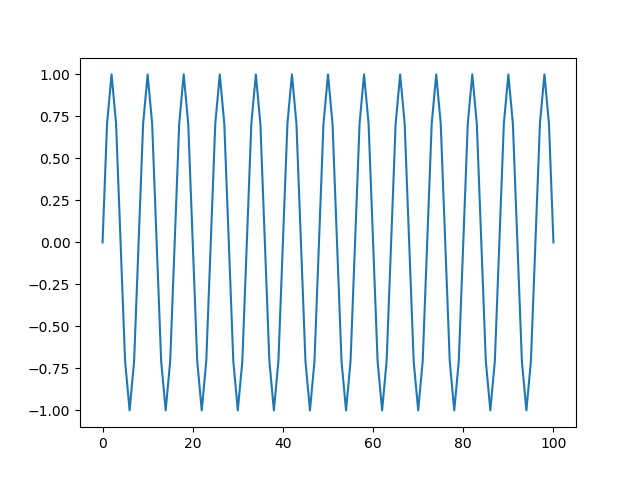

In [31]:
def my_inverse_fourier_transform(x):
    x = np.asarray(x)
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    M = 1/N*np.exp(2j * np.pi * k * n / N)
    # sometimes, the normalisation 1/N here is split between the transformation and its inverse
    # with 1/sqrt(N) for both
    
    return np.dot(M, x)

plt.plot( my_inverse_fourier_transform( my_discrete_fourier_transform(y) ) )

### Confidence intervals of Fourier coefficients

Fourier coefficents have a rather broad sampling distribution (Chi2 distribution).
The poor sampling properties of the individual spectral estimates can make it difficult to discern much about the true spectrum if only a single sample spectrum is available.

<IPython.core.display.Javascript object>


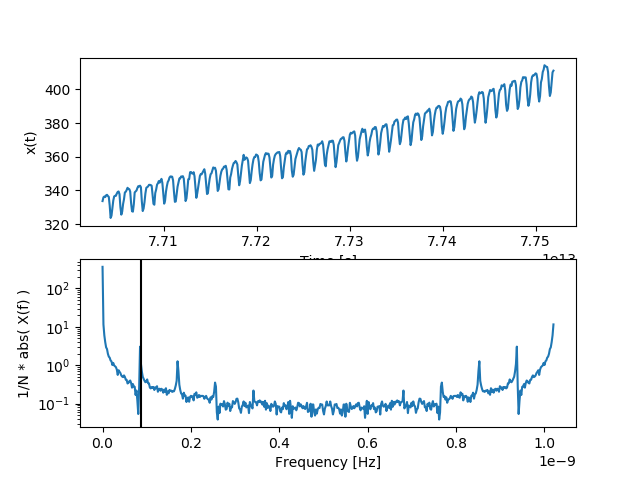

In [36]:
#convert time unit to Days
t=df_co2_month.index.to_julian_date().values*60*60*24*365

y=df_co2_month.Barrow

(ax1,ax2)=plot_fourier_transform(t, y, windowing=False)

#ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.axvline(x=1./(364*60*60*24*365), color='k')
#ax2.axvline(x=2./364, color='r')
#ax2.axvline(x=3./364, color='b')



In [ ]:
df_TA = pd.read_csv('TA_LYR_airport.csv',index_col=0,parse_dates=True)
df_TA.head()

In [ ]:
df_TA_day=df_TA.resample('1D').mean().interpolate().dropna()

#convert time unit to Days
t=df_TA_day.index.to_julian_date().values
y=df_TA_day.TA

(ax1,ax2)=plot_fourier_transform(t, y, windowing=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.axvline(x=1./364, color='k')
ax2.axvline(x=1./2, color='r')

<IPython.core.display.Javascript object>


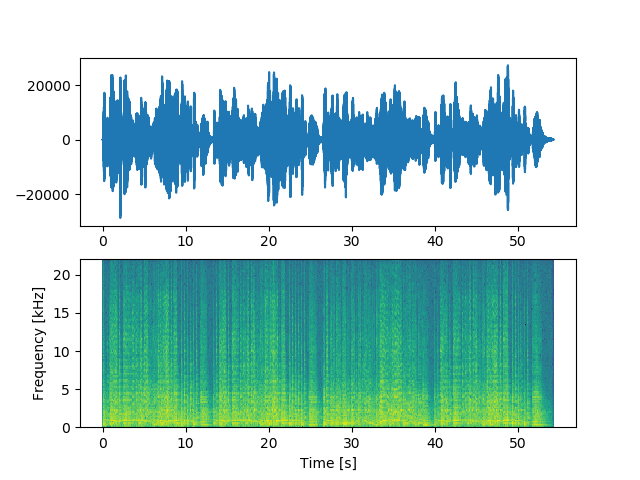

Text(0.5,0,'Time [s]')

In [37]:
# Short-time Fourier transform, using small slices of the time series
from scipy import signal
from scipy.io import wavfile

rate, audio = wavfile.read('a2002011001-e02.wav')
audio = np.mean(audio, axis=1) #make it mono

freqs, times, Sx = signal.spectrogram(audio, fs=rate)

fig = plt.figure()
ax1=fig.add_subplot(211)
ax1.plot(np.arange(len(audio))/rate, audio)

ax2=fig.add_subplot(212,sharex=ax1)
ax2.pcolormesh(times, freqs/1000, 10*np.log10(Sx))
ax2.set_ylabel('Frequency [kHz]')
ax2.set_xlabel('Time [s]')
